In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
class BitcoinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# BiLSTM Model
class BitcoinPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BitcoinPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Advanced architecture with multiple BiLSTM layers
        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Additional layers for better feature extraction
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  # *2 for bidirectional
            num_heads=4,
            dropout=dropout
        )
        
        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # BiLSTM layers
        lstm_out, _ = self.bilstm(x)
        
        # Apply attention mechanism
        attention_out, _ = self.attention(
            lstm_out.permute(1, 0, 2),
            lstm_out.permute(1, 0, 2),
            lstm_out.permute(1, 0, 2)
        )
        attention_out = attention_out.permute(1, 0, 2)
        
        # Take the output from the last time step
        out = attention_out[:, -1, :]
        
        # Fully connected layers with activation and regularization
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        return out

In [ ]:
def prepare_data(df, sequence_length=24):
    # Use OHLCV data
    features = ['open', 'high', 'low', 'close', 'volume']
    data = df[features].values
    
    # Scale the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_scaled) - sequence_length):
        X.append(data_scaled[i:(i + sequence_length)])
        y.append(data_scaled[i + sequence_length, 3])  # Predict close price
    
    # Split data
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return (np.array(X_train), np.array(X_test), 
            np.array(y_train), np.array(y_test), 
            scaler)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_val_loss = float("inf")  # Initialize best validation loss
    best_model_state = None  # Store best model state
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += criterion(y_pred.squeeze(), y_batch).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model based on lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ')
    
    # Load best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses  # Return trained model

In [5]:
def visualize_predictions(model, test_loader, scaler, device):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    # Inverse transform predictions and actuals
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Create dummy array for inverse transform
    dummy = np.zeros((len(predictions), scaler.scale_.shape[0]))
    dummy[:, 3] = predictions.squeeze()  # Close price index
    predictions = scaler.inverse_transform(dummy)[:, 3]
    
    dummy[:, 3] = actuals.squeeze()
    actuals = scaler.inverse_transform(dummy)[:, 3]
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(actuals, label='Actual', alpha=0.8)
    plt.plot(predictions, label='Predicted', alpha=0.8)
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')

# Main execution


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

def main():
    # Load dataset
    df = pd.read_csv('data_15m.csv')  
    
    # Model parameters
    sequence_length = 24  # 24 hours of data
    input_size = 5  # OHLCV features
    hidden_size = 128
    num_layers = 3
    dropout = 0.3
    
    # Prepare data
    X_train, X_test, y_train, y_test, scaler = prepare_data(df, sequence_length)
    
    # Create datasets and dataloaders
    train_dataset = BitcoinDataset(X_train, y_train)
    test_dataset = BitcoinDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BitcoinPredictor(input_size, hidden_size, num_layers, dropout).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Train the model and get the best version
    trained_model, train_losses, val_losses = train_model(
        model, train_loader, test_loader, criterion, optimizer, 
        epochs=20, device=device
    )
    
    # Visualize predictions
    visualize_predictions(trained_model, test_loader, scaler, device)
    
    # Save model checkpoint
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }, 'btc_bilstm_model.pth')

    print("Model saved as btc_bilstm_model.pth")

/Users/anurag2506/miniconda3/envs/mentoroid/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/40], Train Loss: 0.0888, Val Loss: 0.0052, 
Epoch [2/40], Train Loss: 0.0400, Val Loss: 0.0125, 
Epoch [3/40], Train Loss: 0.0265, Val Loss: 0.0033, 
Epoch [4/40], Train Loss: 0.0175, Val Loss: 0.0021, 
Epoch [5/40], Train Loss: 0.0141, Val Loss: 0.0003, 
Epoch [6/40], Train Loss: 0.0115, Val Loss: 0.0011, 
Epoch [7/40], Train Loss: 0.0102, Val Loss: 0.0004, 
Epoch [8/40], Train Loss: 0.0092, Val Loss: 0.0003, 
Epoch [9/40], Train Loss: 0.0085, Val Loss: 0.0001, 
Epoch [10/40], Train Loss: 0.0076, Val Loss: 0.0001, 
Epoch [11/40], Train Loss: 0.0070, Val Loss: 0.0001, 
Epoch [12/40], Train Loss: 0.0066, Val Loss: 0.0003, 
Epoch [13/40], Train Loss: 0.0061, Val Loss: 0.0002, 
Epoch [14/40], Train Loss: 0.0058, Val Loss: 0.0002, 
Epoch [15/40], Train Loss: 0.0054, Val Loss: 0.0001, 
Epoch [16/40], Train Loss: 0.0051, Val Loss: 0.0004, 
Epoch [17/40], Train Loss: 0.0049, Val Loss: 0.0003, 
Epoch [18/40], Train Loss: 0.0050, Val Loss: 0.0001, 
Epoch [19/40], Train Loss: 0.0044, Va

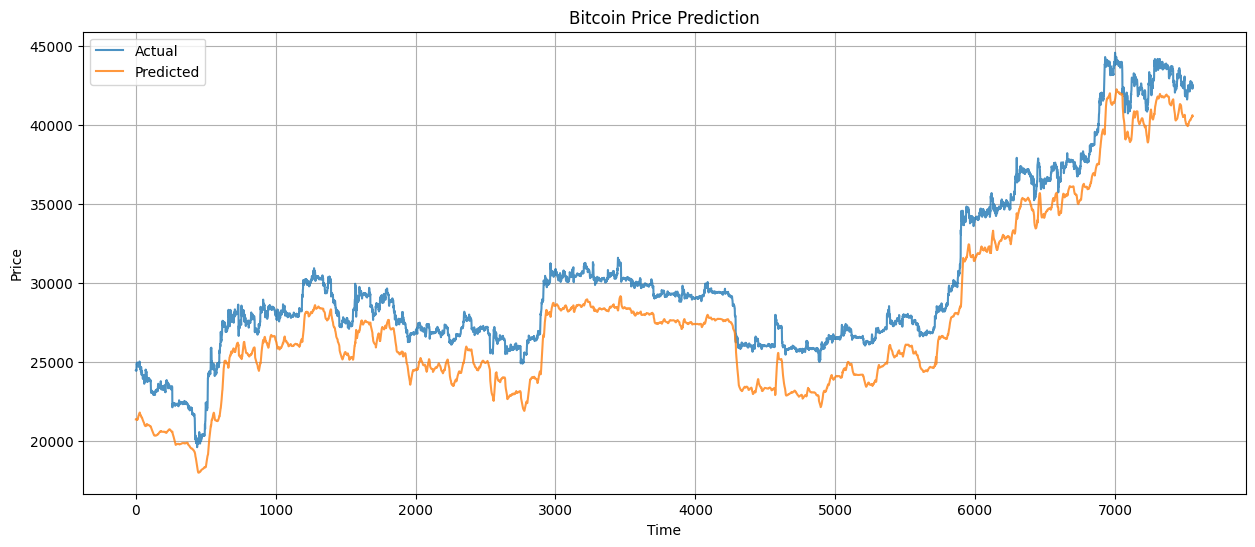

MSE: 5284653.35
RMSE: 2298.84
MAE: 2238.85
Model saved as btc_bilstm_model.pth


In [19]:
if __name__ == "__main__":
    main()